# open bayesian regression
The below notebook will attempt to regress individual 2018 Reebok CrossFit Games Open workout scores using other Open workouts *and* benchmark metrics from athlete profiles. Here, the regression is the score the athlete attained on the workout and *not* their placement relative to other individuals. For example, if an athlete got 10 reps on a 1 minute AMRAP workout, then their score would be 10.

## imports

In [1]:
#pandas (dataframes)
import pandas as pd
#pymysql (mysql connector)
import pymysql as pms
#numpy (reshaping data)
import numpy as np
#scikit-learn
#regression
from sklearn.linear_model import LinearRegression
#train/test split
from sklearn.model_selection import train_test_split
#error calculation
from sklearn.metrics import mean_squared_error
#feature scaling
from sklearn.preprocessing import MinMaxScaler
#plotting
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# use for implementing custom modules
import sys
sys.path.insert(0, "../custom_modules/")

#custom modules
#grabbing data
from dataframer import grab_data
#seaborn styling
import seaborn_styler as sbs
#outlier/normal data separator
from outlier_filter import separate_outliers

### stylize seaborn
This only needs to be done once, and can be done anywhere prior to using Seaborn to achieve the intended styling.

In [2]:
sbs.stylize()

## getting database credentials
The database credentials can be read in from file. Note that this file is ignored in the public repo, so you'll need to make a version which corresponds to your database.

In [3]:
#this list object is passed around to functions requiring database access
#...the functions will open/close the connection themselves during calls
creds = []
#database credentials are stored in this file
with open("../database_credentials2.txt") as f:
    db_user = f.readline().strip()
    db_pass = f.readline().strip()
    db_name = f.readline().strip()
    db_host = f.readline().strip()
    creds = [db_host, db_user, db_pass,db_name]

## grabbing the data
At the time of writing this notebook, division 18 (Men's 35-39) has the most complete open entries. Therefore, we'll use this division for regression. Later, all division data can be scraped, and we can one hot encode the division_id labels.

For predictors, we'll use the Open workouts. There are 6 of them, 5 of which are metcons and 1 of which is a test of olympic weightlifting under fatigue. The independent variables we'll use here will be athlete profile benchmark statistics. These are a mix of strength and endurance tests.

### open workouts
Because of the way the data was filtered during scraping, any athletes who scaled/DNF(did not finish) were not written to the database. Because of this, no `WHERE` criteria is necessary.

In [4]:
#read into dataframe
open_keys = list(map(lambda x: "leaderboard_18_" + x, [
    "1_reps",
    "2_time_secs",
    "2a_weight_lbs",
    "3_time_secs",
    "4_time_secs",
    "5_reps"
]))
working_division = 18

open_data = grab_data(
    """
    SELECT id, {}
    FROM athlete
    WHERE division_id={}
    """.format(
        ", ".join(open_keys), working_division
    ),
    creds
)

open_data.head(3)

,id,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps
0,86,328,651,207,1373,637,77
1,93,309,480,235,1548,642,94
2,1636,402,316,260,1148,577,123


In [5]:
open_data.drop(["id"], axis=1).describe()

,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps
count,24544.000000,24544.000000,24544.000000,24544.000000,24544.000000,24544.000000
mean,281.465328,510.212842,211.107847,1375.548607,579.615751,78.611392
std,58.750398,112.649086,57.220177,366.248177,176.915058,33.489441
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,255.000000,442.000000,188.000000,1312.000000,604.000000,70.000000
50%,284.000000,511.000000,217.000000,1539.000000,623.000000,84.000000
75%,319.000000,585.000000,245.000000,1548.000000,647.000000,99.000000
max,470.000000,829.000000,379.000000,1767.000000,704.000000,191.000000


### benchmark workouts
Although the Open workouts are complete for each entry in the database, the athlete profiles will not be. In fact, *most* athletes do not publish their benchmark stats in a complete manner. To see this, let's try and get the athletes which we have complete benchmark data for.


#### note on fight gone bad
Fight gone bad is a staple workout in CrossFit. Because of a oversight during scraping implementation, all of the first 130,743 athletes have invalid fight gone bad scores marked as -2 (when an entry was given). Because of this, fight gone bad is ignored during this analysis.

In [6]:
benchmark_keys = [
    "back_squat_lbs",
    "clean_and_jerk_lbs",
    "snatch_lbs",
    "deadlift_lbs",
    #"fight_gone_bad_reps",
    "max_pull_ups",
    "fran_time_secs",
    "grace_time_secs",
    "helen_time_secs",
    "filthy_50_time_secs",
    "sprint_400_m_time_secs",
    "run_5_km_time_secs"
]

benchmark_data = grab_data(
    """
    SELECT id, {}
    FROM athlete
    WHERE {}
        AND division_id = {}
        AND max_pull_ups !=- 2
    """.format(
        #key_a, key_b, ...
        ", ".join(benchmark_keys),
        #key_a != -1, key_b != -1, ...
        " AND ".join(list(map(lambda x: x + " != -1", benchmark_keys))),
        working_division
    ),
    creds
)

benchmark_data.head(3)

,id,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
0,86,335,265,210,415,32,226,174,496,1287,64,1325
1,93,305,235,185,355,45,220,154,493,1500,62,1239
2,1636,400,285,215,485,67,138,108,429,1056,58,1219


The below version of `benchmark_data` without the ID column is used throughout the notebook for iteration.

In [7]:
noid_benchmark_df = benchmark_data.drop(["id"], axis=1)
noid_benchmark_df.describe()

,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
count,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000
mean,358.257194,254.546763,202.480216,435.949640,39.976619,268.931655,262.055755,572.672662,1463.692446,122.631295,1351.856115
std,72.477648,47.007720,120.673133,79.178264,15.591907,409.283323,1325.064417,381.082542,516.225184,435.423897,424.966077
min,2.000000,10.000000,10.000000,10.000000,1.000000,119.000000,30.000000,60.000000,50.000000,2.000000,153.000000
25%,315.000000,225.000000,175.000000,396.000000,30.000000,165.000000,120.000000,477.000000,1167.500000,60.000000,1200.000000
50%,355.000000,255.000000,198.000000,440.000000,40.000000,209.000000,150.000000,523.500000,1375.000000,65.000000,1286.000000
75%,400.000000,285.000000,225.000000,485.000000,50.000000,276.250000,204.000000,587.000000,1620.000000,74.000000,1404.250000
max,715.000000,444.000000,2875.000000,726.000000,112.000000,5955.000000,30002.000000,5955.000000,5955.000000,5940.000000,6039.000000


## filtering the open data
Although this filtered dataset is quite small (athletes with complete open profiles), it can still be useful for dimensionality reduction and model evaluation. For exmpaple, specific Open workouts may not exhibit a relationship/dependency on metrics like `deadlift_lbs`. In these cases, athletes who have not filled out the deadlift field on their athlete profile can be included in such a workout analysis.

Below we'll filter the Open data to only those athletes contained in the benchmark dataframe.

In [8]:
filtered_open_df = open_data[open_data["id"].isin(benchmark_data["id"])]

#example data
filtered_open_df.head(3)

,id,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps
0,86,328,651,207,1373,637,77
1,93,309,480,235,1548,642,94
2,1636,402,316,260,1148,577,123


## outlier detection
Although there is a great amount of filtering that happens during data scraping, some outlier-like data is bound to slip in. To see this, look at the max row in the `benchmark_stats` describe call a 3 cells above. In order to filter outliers, we'll first plot 1-dimensional scatterplots for each of the benchmark stats. Notice how we're only talking about the benchmark stats. We're relying on CrossFit HQ's score validation to ensure integrity of Open scores (athletes submit scores to CrossFit and they have the ability to review/reject/adjust scores accordingly).

In [9]:
benchmark_colors = ["#0099ff", "#ff0059", "#66ff33"]

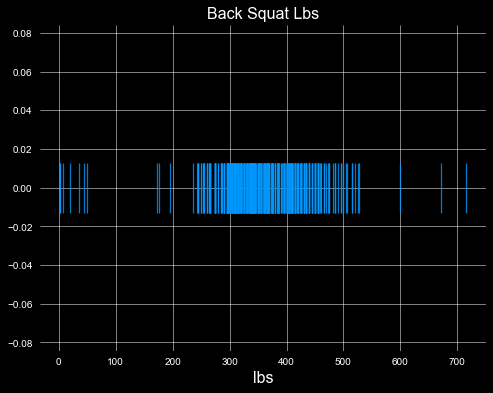

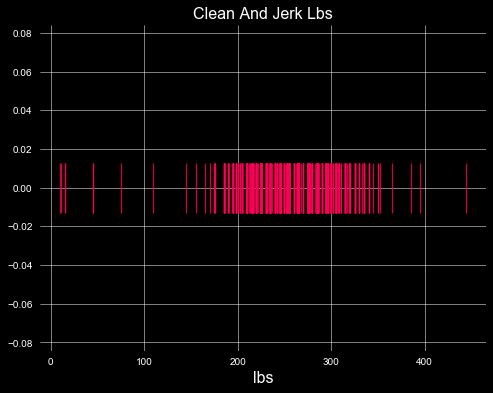

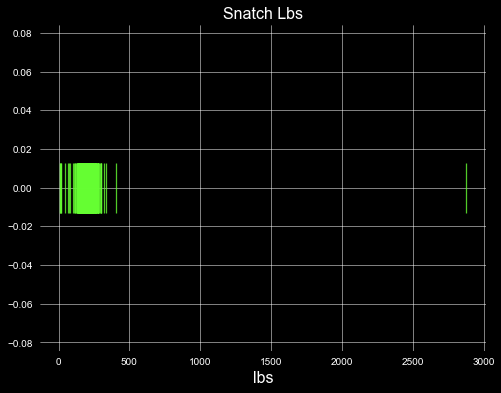

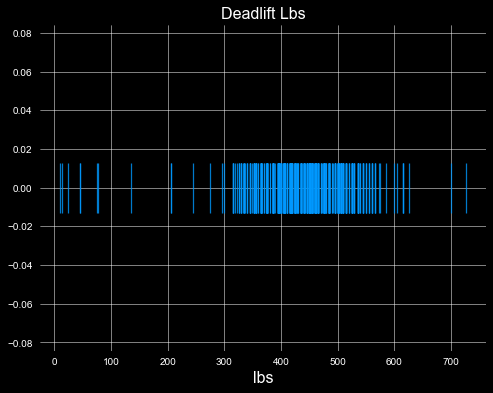

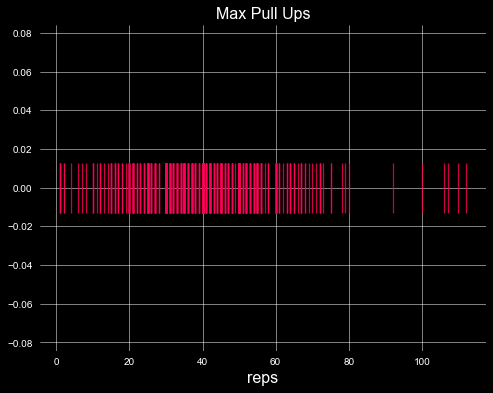

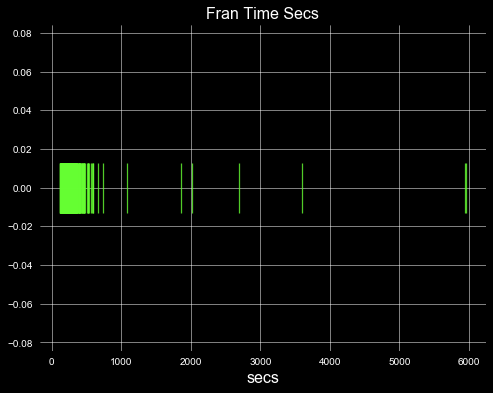

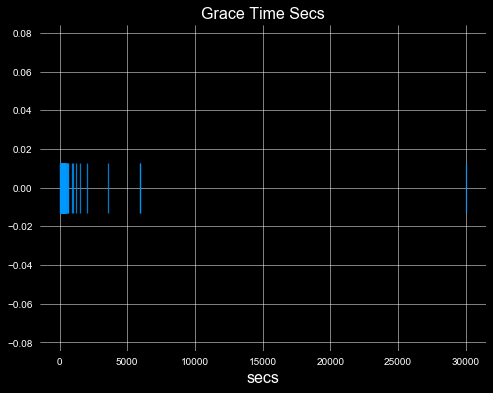

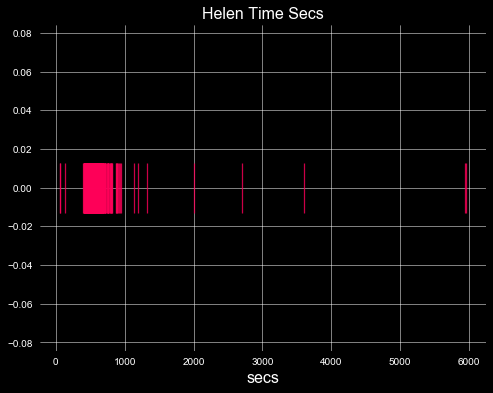

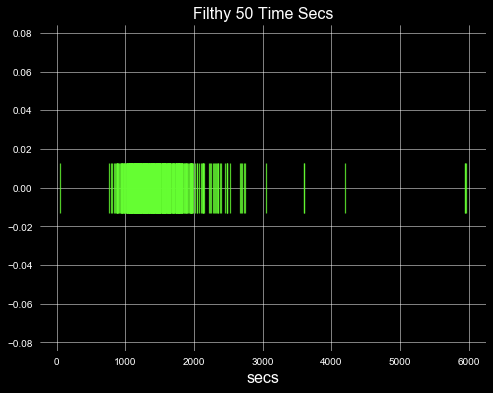

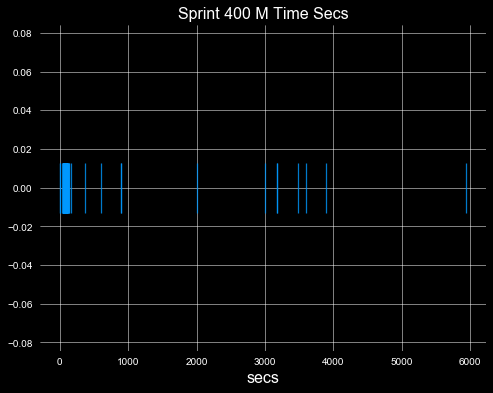

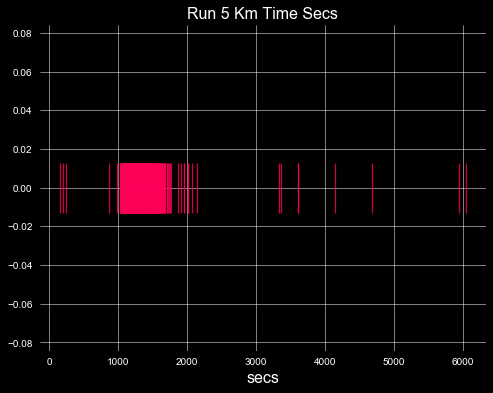

In [10]:
for i in range(len(noid_benchmark_df.columns)):
    #get column reference
    c = noid_benchmark_df.columns[i]
    sb.regplot(
        #x values
        noid_benchmark_df[c],
        #shift each 1d scatterplot up by 1 in the y axis
        np.zeros_like(noid_benchmark_df[c]),
        color=benchmark_colors[i % len(benchmark_colors)],
        fit_reg=False,
        marker="|",
        scatter_kws={"s": 2500}
    )
    #show individual plot
    c_words = c.split("_")
    plt.xlabel(c_words[-1] if c_words[-1] != "ups" else "reps")
    plt.title(c.replace("_", " ").title())
    plt.show()
        

### analyzing the graphs
Below we'll breakdown the workout behind each graph and what kind of entry we'll consider an outlier for each:
* back squat
    * Reasonable [back squat](https://www.youtube.com/watch?v=nOAqpYcyMGs) numbers are anything less than 1000 lbs. However, if an athlete has a backsquat exceeding 3x bodyweight, this is considered advanced strength and should be examined more carefully. To observe this, we'll need to grab the body weight for each of these athletes. Furthermore, we'll do this for clean and jerk, snatch, and deadlift as well.
* clean and jerk
    * From the graph distribution, most of these [clean and jerk](https://www.youtube.com/watch?v=58he7Xcwfws) entries seem reasonable (with the exception of the values < 100 lbs). Still, we'll replot these versus athlete bodyweight for confirmation.
* snatch
    * There's no way somebody is [snatching](https://www.youtube.com/watch?v=FBV-Xw640vQ) 600+ lbs in CrossFit in 2018, so the guy with an entry of 2800+lbs will be removed before replotting vs. bodyweight. Additionally, there are some suspiciously high entries (seeming 300-400 lbs range), so we'll look at these too.
* deadlift
    * Most of these [deadlift](https://www.youtube.com/watch?v=QY9F5-qB5QE) entries seem reasonable. Even the 700 lbs entries are possible, but we'll hold >= 700 and <= 200 as suspicious for the time being.
* max pull ups
    * [Butterfly/kipping](https://www.youtube.com/watch?v=Jp7-5gbtfOY) and [strict](https://www.youtube.com/watch?v=FC74Pa9WTVw) pullups are very difficult to achieve high repitions on (50+ for butterfly/kipping, 30+ for strict). Most if not all of the entries on the athlete profile should correspond to a butterfly/kipping variant. Although many athletes have 50-80 pull ups, we'll plot these scores vs. bodyweight, and pay special attention to athletes claiming 90+ reps.
* fran
    * [Fran](https://www.youtube.com/watch?v=Rlc1O5_43YQ) is meant to be a very fast workout (well under 10 minutes if it's done/scaled properly). Athletes exceeding 600 seconds in their entries most likely haven't updated their profile, are unfit, or, in extremely high-time circumstances, are trolling.
* grace
    * [Grace](https://www.youtube.com/watch?v=_g__U-nkQts), similar to Fran, should be done very quickly (even faster than Fran). High time athletes will be scrutinized after replotting vs. clean and jerk weight.
* helen
    * [Helen](https://www.youtube.com/watch?v=-Y4_0QtOTv4) is a fast workout which tests pulling strength and running. This should be evaluated versus a combination of athlete 400m sprints and pullups/deadlifts.
* filthy 50
    * [Filthy 50](https://www.youtube.com/watch?v=gE0oiHmMdVg) is a long chipper workout. The best time in the world is around ~13 minutes. However, many athletes take close to 30 minutes if they have poor cardio or are not skilled at 1 of the movements. High time scores can be compared to 5k run times, but this is not a great comparison.
* sprint 400m
    * There's no reason anybody should have a 400m time above 5 minutes (300 secs) unless they have trouble walking. For both runs we'll replot against bodyweight.
* run 5km
    * If somebody was walking they could walk 5km (3.1) miles in an hour at a moderate pace. Some athletes competing in the Open may not be able to run for whatever reason, so without knowing why a time is high it's hard to tell if it's bogus. However, if an athlete has a good Filthy 50 and a good Helen, it's unlikely they'd have a poor 5km (this comes from CrossFit intuition and prior experience). This is kind of *hand wavey* here, but we don't have much to go off of.

### replotting the data
Below we'll replot and reanalyze the data taking into consideration the thoughts above. First, let's grab the bodyweight (and why not the height) data for these athletes and attach it to our existing benchmark data.

In [11]:
height_weight_data = grab_data(
    """
    SELECT id, height_in, weight_lbs
    FROM athlete
    WHERE id IN ({})
    """.format(", ".join([str(i) for i in benchmark_data.id])),
    creds
)

height_weight_data.head(3)

,id,height_in,weight_lbs
0,86,77,225
1,93,72,205
2,1636,70,200


Now, let's merge this height_weight_data into the benchmark dataframe.

In [12]:
full_benchmark = height_weight_data.merge(benchmark_data)
full_benchmark.head(3)

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
0,86,77,225,335,265,210,415,32,226,174,496,1287,64,1325
1,93,72,205,305,235,185,355,45,220,154,493,1500,62,1239
2,1636,70,200,400,285,215,485,67,138,108,429,1056,58,1219


Now we'll setup variables required for replotting.

In [13]:
#setup map of variables requiring re-visualization
#the keys are the original variables, values are comparables
replot_map = {}
for c in noid_benchmark_df.columns:
    replot_map[c] = []
replot_map

{'back_squat_lbs': [],
 'clean_and_jerk_lbs': [],
 'deadlift_lbs': [],
 'filthy_50_time_secs': [],
 'fran_time_secs': [],
 'grace_time_secs': [],
 'helen_time_secs': [],
 'max_pull_ups': [],
 'run_5_km_time_secs': [],
 'snatch_lbs': [],
 'sprint_400_m_time_secs': []}

Now add in the comparable benchmarks manually.

In [14]:
#bodyweight dependents
for c in noid_benchmark_df.columns:
    replot_map[c] += ["weight_lbs"]
#grace
replot_map["grace_time_secs"] += ["clean_and_jerk_lbs"]
#helen
replot_map["helen_time_secs"] += ["sprint_400_m_time_secs", "deadlift_lbs", "max_pull_ups"]
#filthy 50
replot_map["filthy_50_time_secs"] += ["run_5_km_time_secs"]
replot_map

{'back_squat_lbs': ['weight_lbs'],
 'clean_and_jerk_lbs': ['weight_lbs'],
 'deadlift_lbs': ['weight_lbs'],
 'filthy_50_time_secs': ['weight_lbs', 'run_5_km_time_secs'],
 'fran_time_secs': ['weight_lbs'],
 'grace_time_secs': ['weight_lbs', 'clean_and_jerk_lbs'],
 'helen_time_secs': ['weight_lbs',
  'sprint_400_m_time_secs',
  'deadlift_lbs',
  'max_pull_ups'],
 'max_pull_ups': ['weight_lbs'],
 'run_5_km_time_secs': ['weight_lbs'],
 'snatch_lbs': ['weight_lbs'],
 'sprint_400_m_time_secs': ['weight_lbs']}

We'll highlight data outside a specified number of standard deviations of the mean in a different color. In order to grab these points, we'll use a function we've written in a [separate module](../custom_modules/outlier_filter.py).

In [28]:
pd.DataFrame([[1, 1], [2, 1], [3, 1], [4, 1], [5, 200], [6, 1], [7, 1], [8, 1]], columns=["id", "something"]).describe()

,id,something
count,8.00000,8.000000
mean,4.50000,25.875000
std,2.44949,70.357125
min,1.00000,1.000000
25%,2.75000,1.000000
50%,4.50000,1.000000
75%,6.25000,1.000000
max,8.00000,200.000000


In [39]:
#we'll use this standard deviation count as our limit for "normal" considered data
working_std_lim = 3
#returns 2 dataframes
separate_outliers(
    1.5,
    pd.DataFrame([[i, 1] for i in range(10)] + [[30, 100]], columns=["id", "something"]),
    "something"
)

(   id  something
 0   0          1
 1   1          1
 2   2          1
 3   3          1
 4   4          1
 5   5          1
 6   6          1
 7   7          1
 8   8          1
 9   9          1,     id  something
 10  30        100)

Now let's iteratively replot the data against the specified "useful" benchmarks.

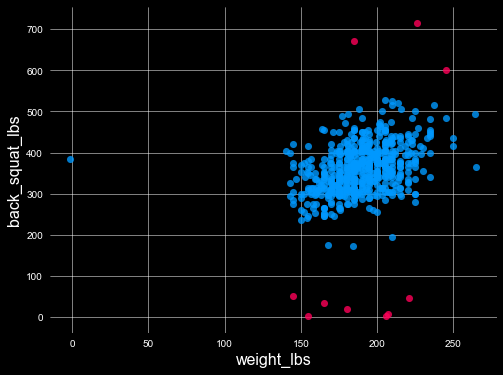

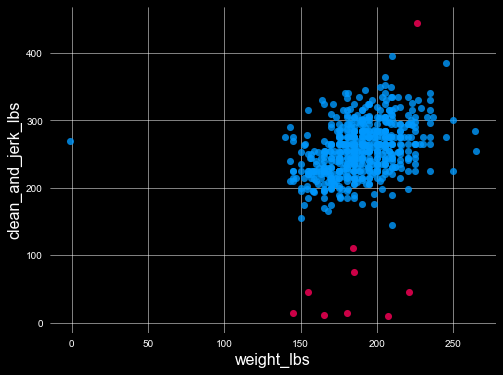

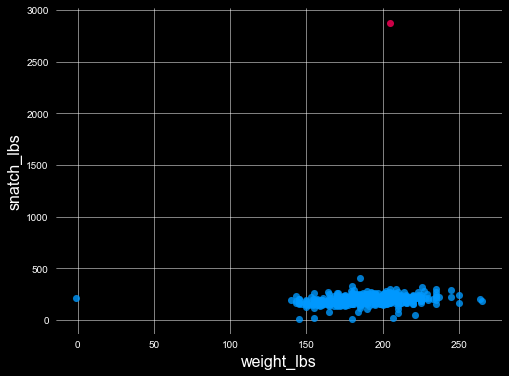

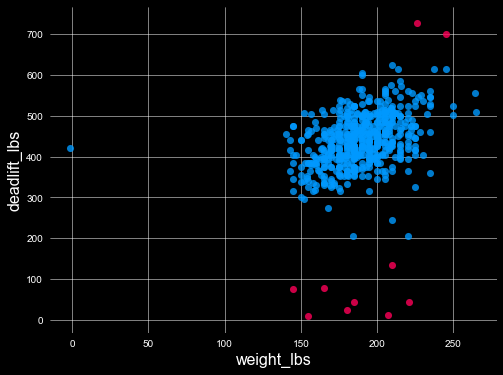

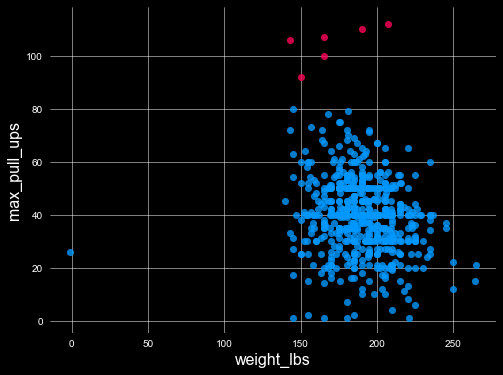

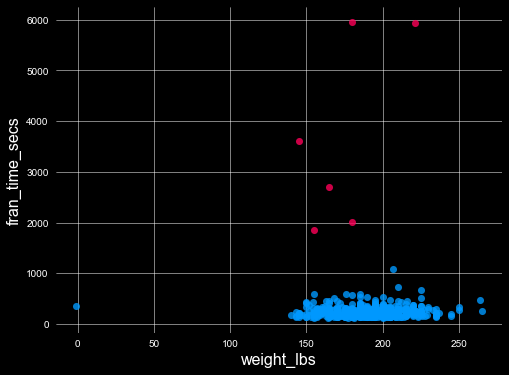

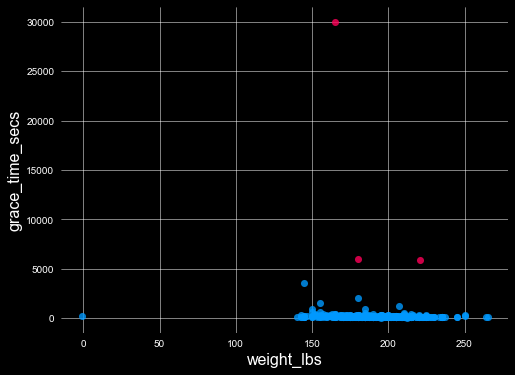

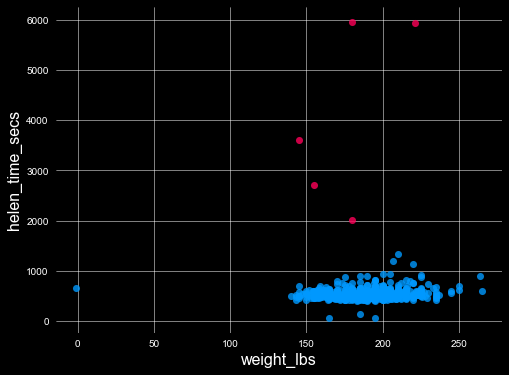

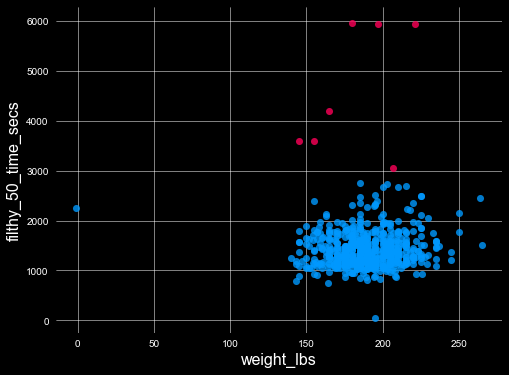

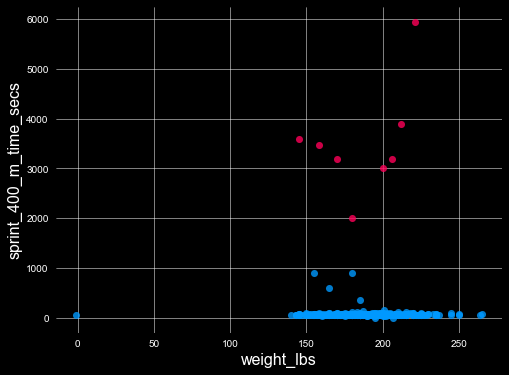

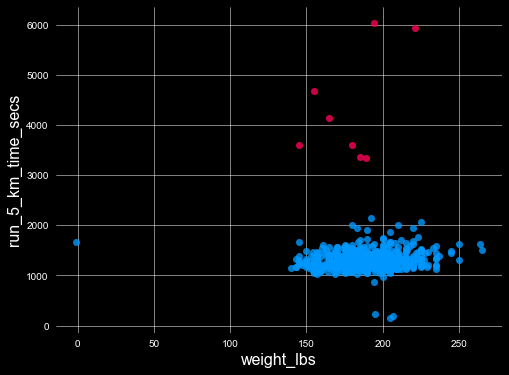

In [50]:
#iterate over benchmarks in same order as before
for i in range(len(noid_benchmark_df.columns)):
    #get column reference
    c = noid_benchmark_df.columns[i]
    
    #get data split normal/abnormal
    normal, abnormal = separate_outliers(
        working_std_lim,
        full_benchmark[[c] + replot_map[c]],
        c
    )
    
    #plot data
    data = [normal, abnormal]
    #if data only relies on 1 comparable
    if len(replot_map[c]) == 1 or True:
        #iterate over the splits
        for j in range(len(data)):
            sb.regplot(
                #x values
                data[j][replot_map[c][0]],
                #y values
                data[j][c],
                #color dataset accordingly
                color=benchmark_colors[j],
                fit_reg=False,
                marker="o",
                scatter_kws={"s": 50}
            )
    #show individual plot
    #c_words = c.split("_")
    #plt.xlabel(c_words[-1] if c_words[-1] != "ups" else "reps")
    #plt.title(c.replace("_", " ").title())
    plt.show()

In [43]:
abnormal

,back_squat_lbs,weight_lbs
59,45,221
73,2,206
214,671,185
273,715,226
274,7,207
323,600,245
352,50,145
382,35,165
552,2,155
553,20,180


## scaling the data
Before fitting this data to a learner, it's important to mention that these workouts are in a bunch of different metrics: weight, time, pounds. Because of this, we'll first scale the scale/normalize the data to the range [0,1]. In doing this, variable weights for say, deadlift, which can exceed a value of 600lbs (600), won't outweigh metrics which have lower values, like max pull ups (0-110).

However, it's common that models which measure distances/similarities between data entries (kNN) are more affected by feature scaling than those which do not (Naive Bayes). Because we're using a bayesian regression model from scikit-learn, it's likely that feature scaling is not necessary. However, we may choose to apply different learners later, so for now we'll do feature scaling.

In [ ]:
mms = MinMaxScaler()


## splitting data into train/test sets

In [ ]:
#ratio of data to be used for testing
test_ratio = .2
#random state used for ML initialization
random_state = 0

In [ ]:
#doesn't really matter which variable is used here as (in)dependent
x_train, x_test, y_train, y_test = train_test_split(
    #x
    squat_deadlift.squat,
    #y
    squat_deadlift.deadlift,
    test_size=test_ratio,
    random_state=random_state
)

## linear regression
Below we apply scikit-learn's [linear regression](http://scikit-learn.org/stable/auto_examples/plot_isotonic_regression.html#sphx-glr-auto-examples-plot-isotonic-regression-py) to the squat/deadlift data, using squat weight (in lbs) to predict deadlift weight (in lbs). Note that these values are 1 rep maxes (the maximum amount of weight an athlete has attested to lifting for 1 rep).

In [ ]:
regressor = LinearRegression()
regressor.fit(x_train[:, np.newaxis], y_train)

### plotting regression
The data can be plotted using Seaborn's [regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html).

In [ ]:
#colors for plotting
color_map = {
    "scatter": {
        "train": "#33ccff",
        "test": "#ff0059"
    },
    "regression": {
        "predict": "#66ff33"
    }
}

#training/testing dataframes
df_train = pd.concat([x_train, y_train], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)
df_preds = pd.DataFrame(x_test.values, columns=["squat"])
df_preds["deadlift"] = pd.Series(regressor.predict(x_test.values[:, np.newaxis]))

#used to make plotting less repetitive
colors_scatter = [color_map["scatter"]["train"], color_map["scatter"]["test"]]
labels = ["train", "test"]
dfs = [df_train, df_test]

#plotting scatter plots
for i in range(len(dfs)):
    ax = sb.regplot(
        x="squat",
        y="deadlift",
        data=dfs[i],
        fit_reg=False,#default true
        color=colors_scatter[i],
        scatter_kws={"s": 25},
        label=labels[i],
        marker="o"
    )

#plotting regression (from model predicting based on x_test)
ax = sb.regplot(
    x="squat",
    y="deadlift",
    data=df_preds.head(2),
    scatter=False,#default true
    color=color_map["regression"]["predict"],
    label="predict"
)
plt.title("Squat vs. Deadlift (lbs)")
plt.legend()
plt.show()
#testing data
#ax = sb.regplot(x="squat", y="deadlift", data=df_test, fit_reg=False, color=colors["scatter"]["test"])

## analyzing regression fit
The regression looks like it fits the data well, but because the data has a decent spread, let's use some metrics to analyze it's performance.

In [ ]:
#r2
print(
    "R2 score: {}".format(
        regressor.score(
            df_test["squat"][:, np.newaxis],
            df_test["deadlift"][:, np.newaxis]
        )
    )
)

#rmse
print(
    "RMSE: {}".format(
        mean_squared_error(
            df_test["deadlift"][:, np.newaxis],
            df_preds["deadlift"][:, np.newaxis]
        )
    )
)

Analyziing the R2 specifically, it seems as though only 50% of the variation in deadlifts observed in the women's 45-49 division can be explained by looking at the back squat. Because of this, observing the back squat alone is most likely not a strong enough metric to try and predict athlete deadlifts. However, explaining 50% of the deadlift variation IS significant. Perhaps this regression could be done again, taking into account cleans, snatches, or 2k rows.